In [3]:
import os
import random

from fastai import *
from fastai.tabular import *
from fastai.callbacks.tracker import EarlyStoppingCallback
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

%reload_ext autoreload
%autoreload 2

In [4]:
path = Path('data')

In [5]:
df = pd.read_csv(path/'train.csv')

In [6]:
test_df = pd.read_csv(path/'test.csv').set_index('ID_code')

In [16]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [17]:
test_df.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [7]:
# From QuangHoàng
# https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble/notebook

class roc(Callback):
    '''
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, num_batch, **kwargs):
        self.metric = self.total/self.batch_count

In [8]:
bs = 512
dep_var = 'target'
cat_names = []
cont_names = [feature for feature in df.columns if 'var' in feature]
procs = [FillMissing, Normalize]
earlystop = partial(EarlyStoppingCallback, monitor='roc', min_delta=0.01, patience=3)

In [9]:
# From QuangHoàng
# https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble/notebook

random.seed(5683)
valid_idx = random.sample(list(df.index.values), int(len(df)*0.05) )

# verify that positive sample distribution in validation set is similar to that of the whole data
df.iloc[valid_idx].target.sum() / len(valid_idx) , df.target.sum() / len(df)

(0.1028, 0.10049)

In [8]:
# test = TabularList.from_df(test_df, path=path, cat_names=cat_names, cont_names=cont_names)

In [9]:
# data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .random_split_by_pct(0.15)
#                            .label_from_df(cols=dep_var)
#                            .add_test(test)
#                            .databunch())

In [10]:
data = TabularDataBunch.from_df(path=path, df=df, 
                                dep_var=dep_var, 
                                valid_idx=valid_idx, 
                                cat_names=cat_names, 
                                cont_names=cont_names, 
                                bs=bs,
                                procs=procs,
                                test_df=test_df)

In [11]:
# create and load trained learner

learn = tabular_learner(data, 
                        layers=[200,100], 
                        ps=[0.4, 0.2], 
                        metrics=[accuracy, roc()],callback_fns=[earlystop]).load('v3 200-100 roc 0.861')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


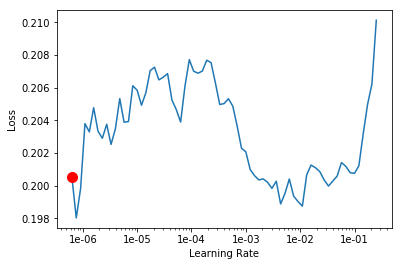

In [12]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(15, 3e-02)

epoch,train_loss,valid_loss,accuracy,roc,time
1,0.261460,0.245132,0.911100,0.850357,00:03
2,0.236489,0.238285,0.914200,0.854821,00:03
3,0.233276,0.236693,0.913400,0.855827,00:03
4,0.234641,0.237799,0.911700,0.859961,00:03
5,0.229907,0.246039,0.906300,0.860707,00:03
6,0.226698,0.239771,0.911900,0.857500,00:02
7,0.221759,0.233474,0.914800,0.860738,00:02
8,0.218785,0.232864,0.915600,0.861508,00:03


Epoch 9: early stopping


In [32]:
learn.save('v3 200-100 roc 0.861')

In [13]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [14]:
preds

tensor([[0.4575, 0.5425],
        [0.5262, 0.4738],
        [0.8846, 0.1154],
        ...,
        [0.9945, 0.0055],
        [0.9546, 0.0454],
        [0.9364, 0.0636]])

In [15]:
test_probs = np.array(preds[:, 1])

In [16]:
test_probs

array([0.542461, 0.473771, 0.115446, 0.118627, ..., 0.019548, 0.005458, 0.045431, 0.063603], dtype=float32)

In [17]:
sub_df = pd.DataFrame({'ID_code': test_df.index, 'target': test_probs})

In [21]:
sub_df.head()

,ID_code,target
0,test_0,0.542461
1,test_1,0.473771
2,test_2,0.115446
3,test_3,0.118627
4,test_4,0.083596


In [20]:
sub_df.to_csv('submission1.csv', index=False)